<a href="https://colab.research.google.com/github/sundarbee/DataEngineering/blob/master/LinearRegression_Hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [147]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [148]:
train.shape


(8523, 12)

In [149]:
test.shape

(5681, 11)

In [150]:
CURRENT_YEAR = 2013

for df in [train, test]:
    # Standardize labels
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

    # Fill missing
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) #Global Mean fix - GroupBy Appropriate categories and take group median Assignment
    df['Item_Visibility'] = df['Item_Visibility'].replace(0, df['Item_Visibility'].median()) #Global Median fix - GroupBy Appropriate categories and take group median Assignment
    df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True) #Global Mean fix - GroupBy Appropriate categories and take group median Assignment

    df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])
    df['Outlet_age'] = CURRENT_YEAR - df['Outlet_Establishment_Year']
    df['Visibility_MeanRatio'] = df['Item_Visibility']/df['Item_Visibility'].mean()
    df['Outlet_Location_Score'] = df['Outlet_Location_Type'].map({"Tier 1":1,"Tier 2":2,"Tier 3":3})
    df['High_MRP_Flag'] = (df['Item_MRP'] > df['Item_MRP'].median()).astype(int)

In [151]:
train.isna().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

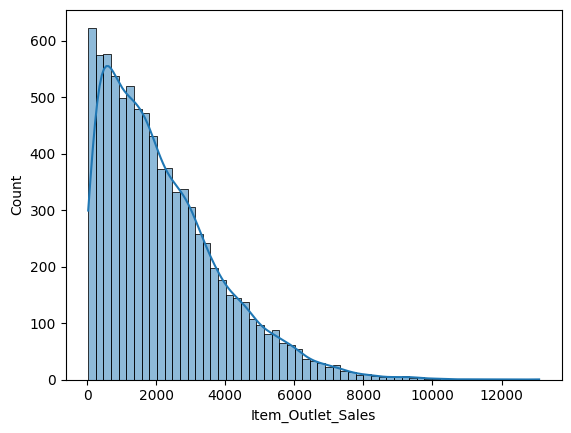

In [152]:
sns.histplot(train['Item_Outlet_Sales'],kde = True)

<Axes: ylabel='Item_Visibility'>

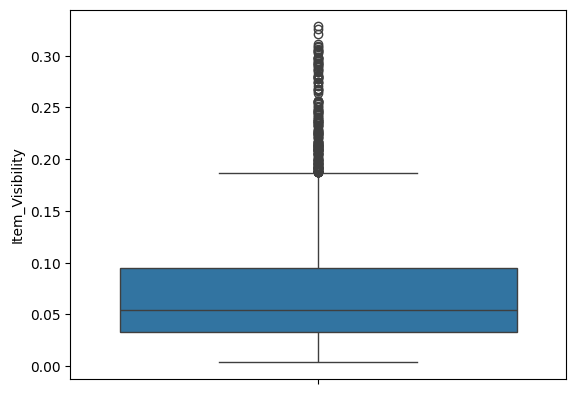

In [153]:
sns.boxplot(train['Item_Visibility'])

In [154]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Outlet_age',
 'Visibility_MeanRatio',
 'Outlet_Location_Score',
 'High_MRP_Flag']

<Axes: ylabel='Item_Weight'>

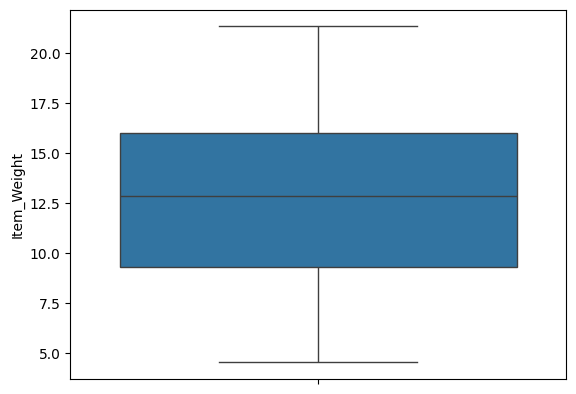

In [155]:
sns.boxplot(train['Item_Weight'])

<Axes: ylabel='Item_MRP'>

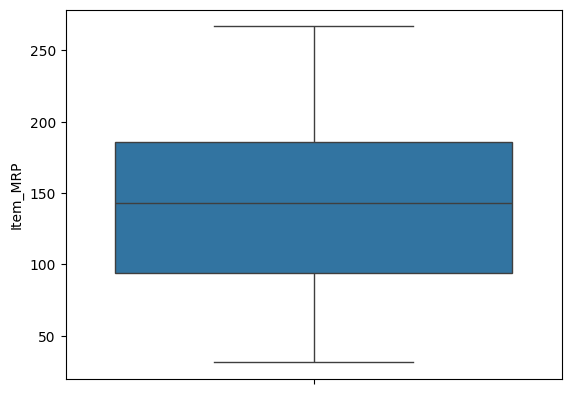

In [156]:
sns.boxplot(train['Item_MRP'])

<Axes: ylabel='Outlet_Establishment_Year'>

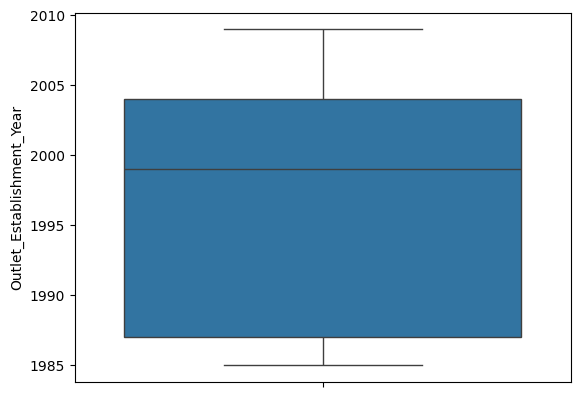

In [157]:
sns.boxplot(train['Outlet_Establishment_Year'])

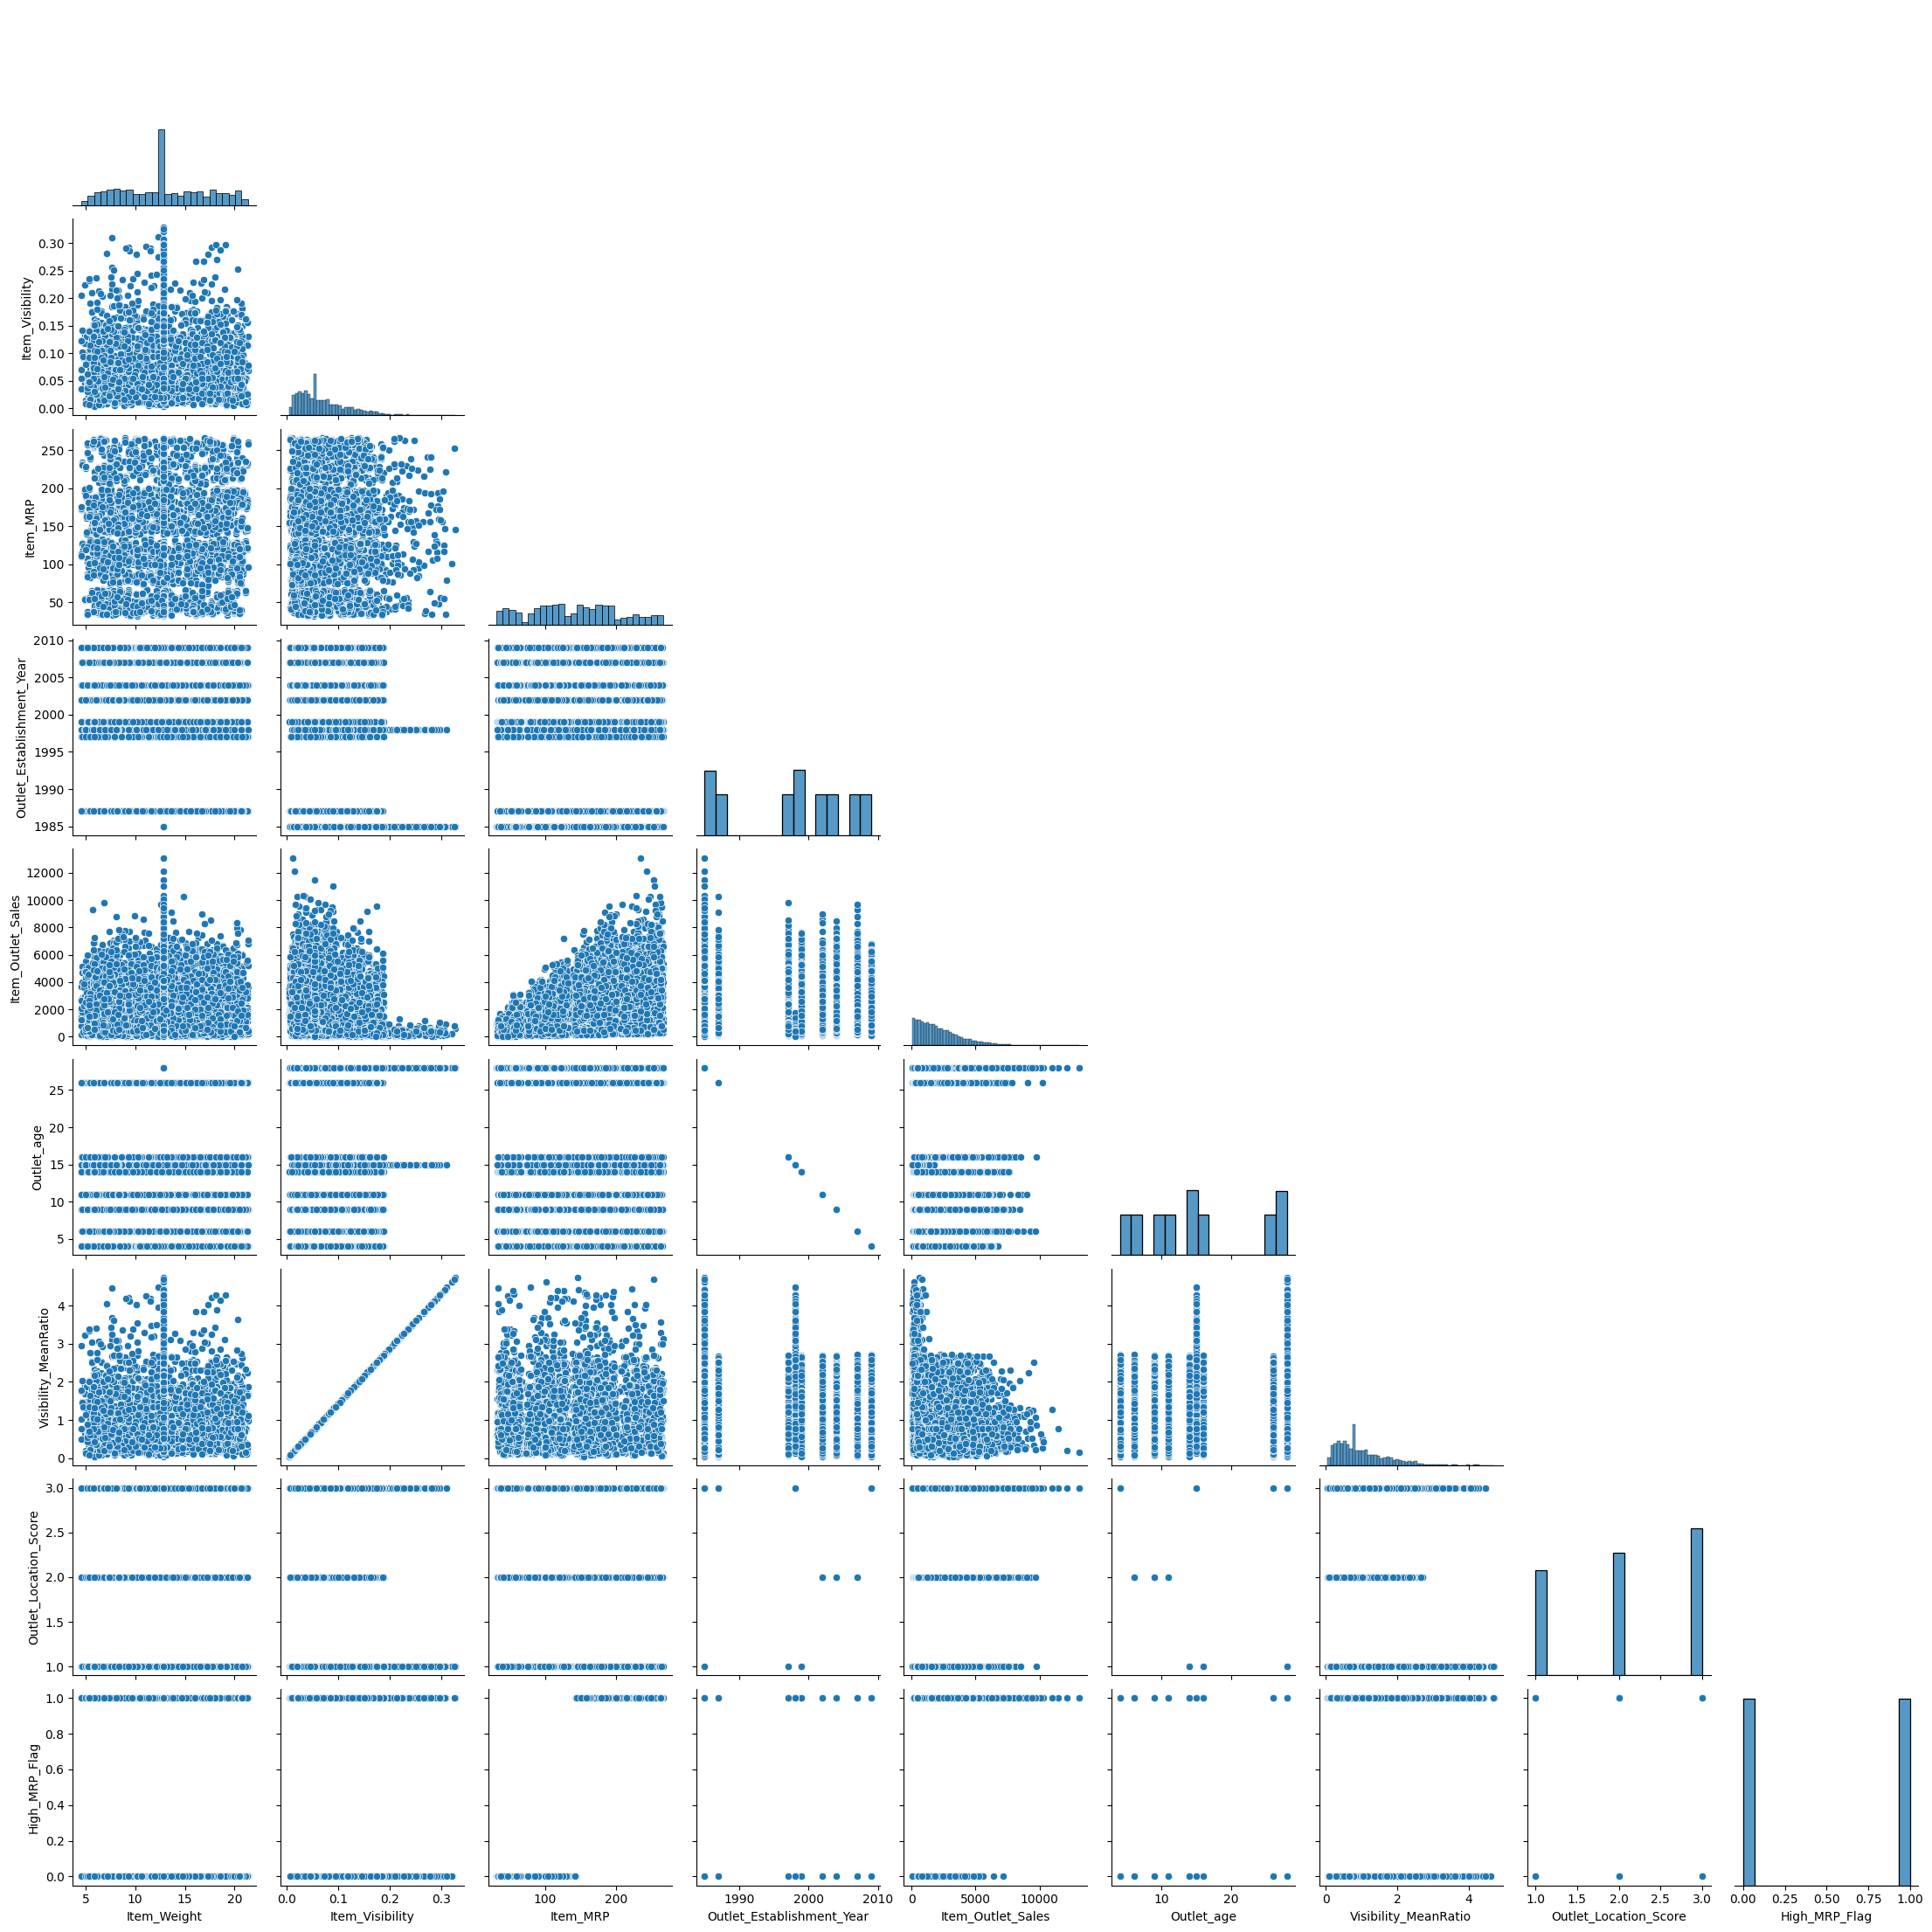

In [158]:
sns.pairplot(train[num_cols],corner=True)

In [159]:
#1. Strong linear relationship (MRP-Sales)
#2. Weak relationships (visibility and weight vs Sales)
#3. Distributions along the diagonal reveal right-skewness.. WE can do log-transformations before modelling for this..

In [160]:
## Preprocessings:

# 1. LF - Regular fix
# 2. Itemweight - Missing values - MEan
# 3. Outlet_size - Missing values - Mode
# 4. Item_Visibility - fix 0s with Median

1. Ratios & interaction proportions
2. Aggregated Statistical Features
3. Non-Linear Transformations #optional
4. Encoding

In [161]:
train[num_cols].corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_age,Visibility_MeanRatio,Outlet_Location_Score,High_MRP_Flag
Item_Weight,1.000000,-0.016533,0.024756,-0.008301,0.011550,0.008301,-0.016533,0.004088,0.025471
Item_Visibility,-0.016533,1.000000,-0.004531,-0.078271,-0.134095,0.078271,1.000000,-0.028120,0.003649
Item_MRP,0.024756,-0.004531,1.000000,0.005020,0.567574,-0.005020,-0.004531,0.000232,0.843347
Outlet_Establishment_Year,-0.008301,-0.078271,0.005020,1.000000,-0.049135,-1.000000,-0.078271,-0.089216,-0.005651
Item_Outlet_Sales,0.011550,-0.134095,0.567574,-0.049135,1.000000,0.049135,-0.134095,0.089367,0.485460
Outlet_age,0.008301,0.078271,-0.005020,-1.000000,0.049135,1.000000,0.078271,0.089216,0.005651
Visibility_MeanRatio,-0.016533,1.000000,-0.004531,-0.078271,-0.134095,0.078271,1.000000,-0.028120,0.003649
Outlet_Location_Score,0.004088,-0.028120,0.000232,-0.089216,0.089367,0.089216,-0.028120,1.000000,-0.004603
High_MRP_Flag,0.025471,0.003649,0.843347,-0.005651,0.485460,0.005651,0.003649,-0.004603,1.000000


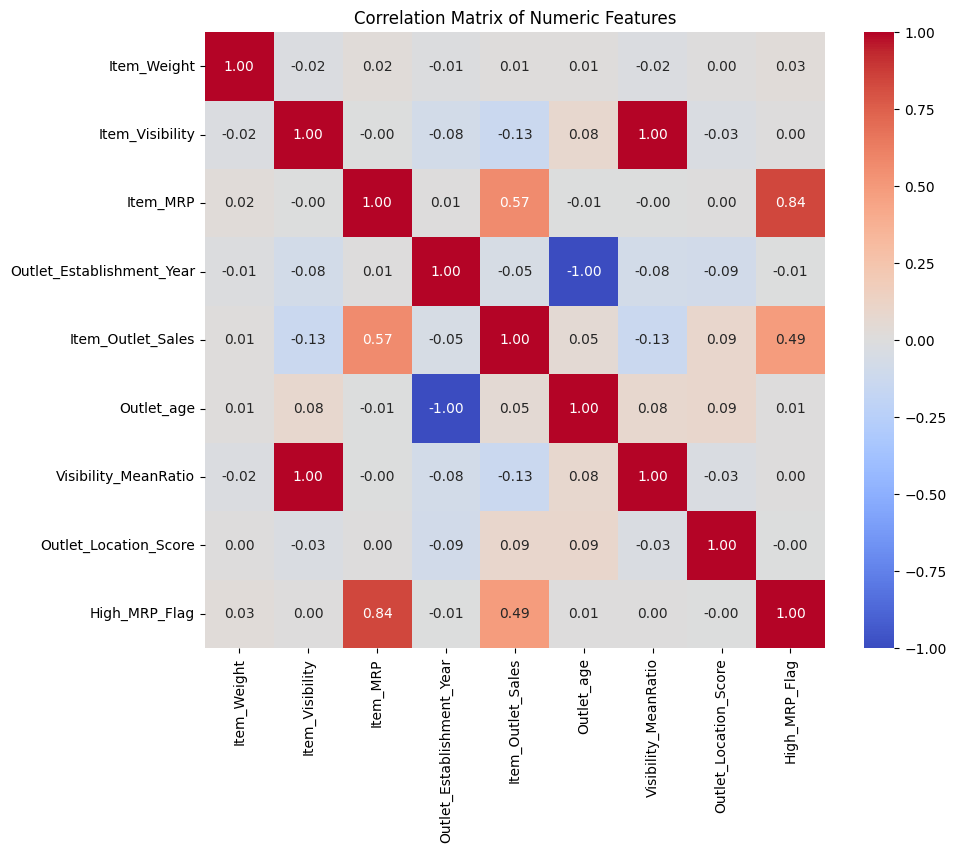

In [162]:
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [163]:
# Chi-square test for categorical vs target
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

cat_cols = train.select_dtypes(exclude=np.number).columns
chi_results = []

#Chi-Square is a test for variance
for c in cat_cols:
    contingency = pd.crosstab(train[c], pd.qcut(train["Item_Outlet_Sales"], q=4)) #4Quartilee
    chi2_stat, p, dof, ex = chi2_contingency(contingency)
    chi_results.append((c, chi2_stat, p))
    #H0 - No association between each categorical variable and binned sales
    #HA - Strong Relationship (p<0.05) reject Null
chi_df = pd.DataFrame(chi_results, columns=["Feature","Chi2","p_value"]).sort_values("p_value")
print("Chi-Square association with Item_Outlet_Sales (lower p = stronger association):")
display(chi_df)

Chi-Square association with Item_Outlet_Sales (lower p = stronger association):


,Feature,Chi2,p_value
3,Outlet_Identifier,3679.210196,0.000000e+00
6,Outlet_Type,3647.922343,0.000000e+00
0,Item_Identifier,7454.138969,1.486821e-132
5,Outlet_Location_Type,282.177067,5.372026e-58
4,Outlet_Size,119.632597,1.946431e-23
7,Item_Category,27.515132,1.159189e-04
2,Item_Type,88.372933,1.204309e-04
1,Item_Fat_Content,5.429388,1.429235e-01


<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

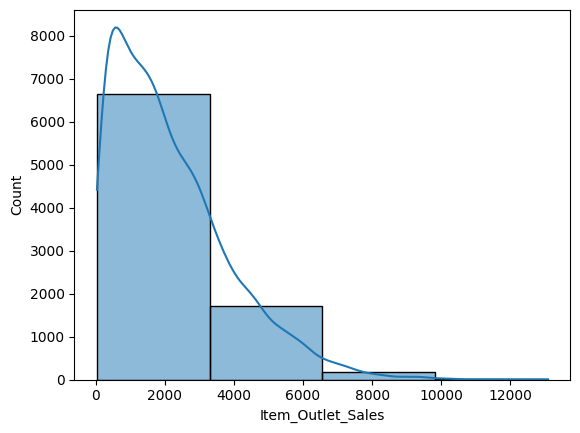

In [164]:
sns.histplot(train['Item_Outlet_Sales'],kde = True,bins=4)

In [165]:
# Chi-square test for categorical vs target
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

cat_cols = train.select_dtypes(exclude=np.number).columns
chi_results = []

#Chi-Square is a test for variance
for c in cat_cols:
    contingency = pd.crosstab(train[c], pd.qcut(train["Item_Outlet_Sales"], q=4)) #4Quartilee
    chi2_stat, p, dof, ex = chi2_contingency(contingency)
    chi_results.append((c, chi2_stat, p))
    #H0 - No association between each categorical variable and binned sales
    #HA - Strong Relationship (p<0.05) reject Null
chi_df = pd.DataFrame(chi_results, columns=["Feature","Chi2","p_value"]).sort_values("p_value")
print("Chi-Square association with Item_Outlet_Sales (lower p = stronger association):")
display(chi_df)

Chi-Square association with Item_Outlet_Sales (lower p = stronger association):


,Feature,Chi2,p_value
3,Outlet_Identifier,3679.210196,0.000000e+00
6,Outlet_Type,3647.922343,0.000000e+00
0,Item_Identifier,7454.138969,1.486821e-132
5,Outlet_Location_Type,282.177067,5.372026e-58
4,Outlet_Size,119.632597,1.946431e-23
7,Item_Category,27.515132,1.159189e-04
2,Item_Type,88.372933,1.204309e-04
1,Item_Fat_Content,5.429388,1.429235e-01


In [166]:
target = "Item_Outlet_Sales"

features = ["Item_Weight",'Item_Visibility','Item_MRP','Outlet_age','Outlet_Location_Score','Item_Type','Item_Category',
            'Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier']

X = train[features]
y = train[target]

X_test = test[features]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [167]:
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age',
       'Outlet_Location_Score'],
      dtype='object')

In [168]:
cat_cols

Index(['Item_Type', 'Item_Category', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Outlet_Identifier'],
      dtype='object')

In [169]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("cat", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
lin_pipe = Pipeline([('prep',preprocessor),
                     ('model',LinearRegression())])

In [170]:
lin_pipe.fit(X,y) #Gradient descent is happening here..!
y_pred = lin_pipe.predict(X)

In [171]:
r2 = r2_score(y,y_pred)
rmse = np.sqrt(mean_squared_error(y,y_pred))

In [172]:
r2

0.5636337028454182

In [173]:
rmse

np.float64(1127.2138485537246)

In [179]:
preds = lin_pipe.predict(X_test)
preds = np.clip(preds, 0,None)
submission = pd.DataFrame({'Item_Identifier':test['Item_Identifier'],
                           'Outlet_Identifier':test['Outlet_Identifier'],
                           'Item_Outlet_Sales':preds})
submission.to_csv('Submission_LR_CF.csv',index=False)

In [ ]:
from sklearn.linear_model import SGDRegressor

gd_lrmodel = SGDRegressor()
gd_lrmodel.fit(X,y)